In [74]:
import pandas as pd

df = pd.read_csv('Online Retail.csv')
df.head(10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [75]:
df.shape


(541909, 8)

In [76]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [77]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [78]:
df = df.drop_duplicates()

In [79]:
# Hapus missing value pada CustomerID
df = df.dropna(subset=['CustomerID'])

In [80]:
# Ubah InvoiceDate ke datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [81]:
# Filter hanya nilai Quantity dan UnitPrice positif
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [82]:
# Hitung nilai sales
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [83]:
# Hitung snapshot date untuk Recency
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [84]:
# Hitung nilai RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

In [85]:
# Rename kolom
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [86]:
rfm = rfm[rfm['Monetary'] > 0]

In [87]:
# RFM Scoring
rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)


In [88]:
rfm['Segment'] = rfm['RFM_Score'].apply(lambda x: 'Best' if x == '444' else 'Others')

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [90]:
# Fitur dan label
df['Sales'] = df['Quantity'] * df['UnitPrice']
X = df[['Quantity', 'UnitPrice']]
y = df['Sales']



In [91]:
# Tempatkan sebelum split
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Sales'] >= Q1 - 1.5 * IQR) & (df['Sales'] <= Q3 + 1.5 * IQR)]


In [92]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [93]:
# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [94]:
# Latih model
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [95]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Evaluasi model regresi
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


MSE: 91853.31
RMSE: 303.07
R² Score: 0.75


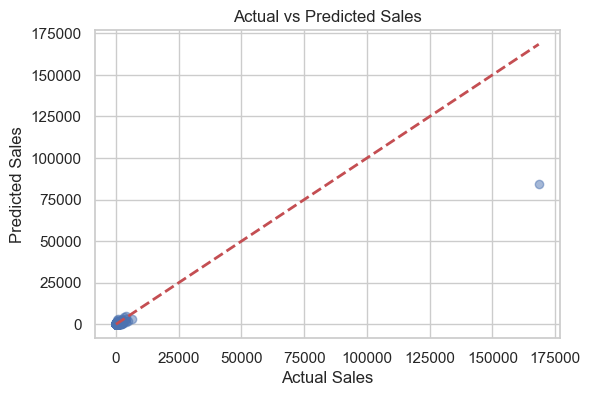

In [96]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.grid(True)
plt.show()


In [97]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", scores)


Cross-Validated R² Scores: [0.46425209 0.41290109 0.96377597 0.11646209 0.48282306]


In [98]:
import joblib
joblib.dump(model, "model_regresi.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

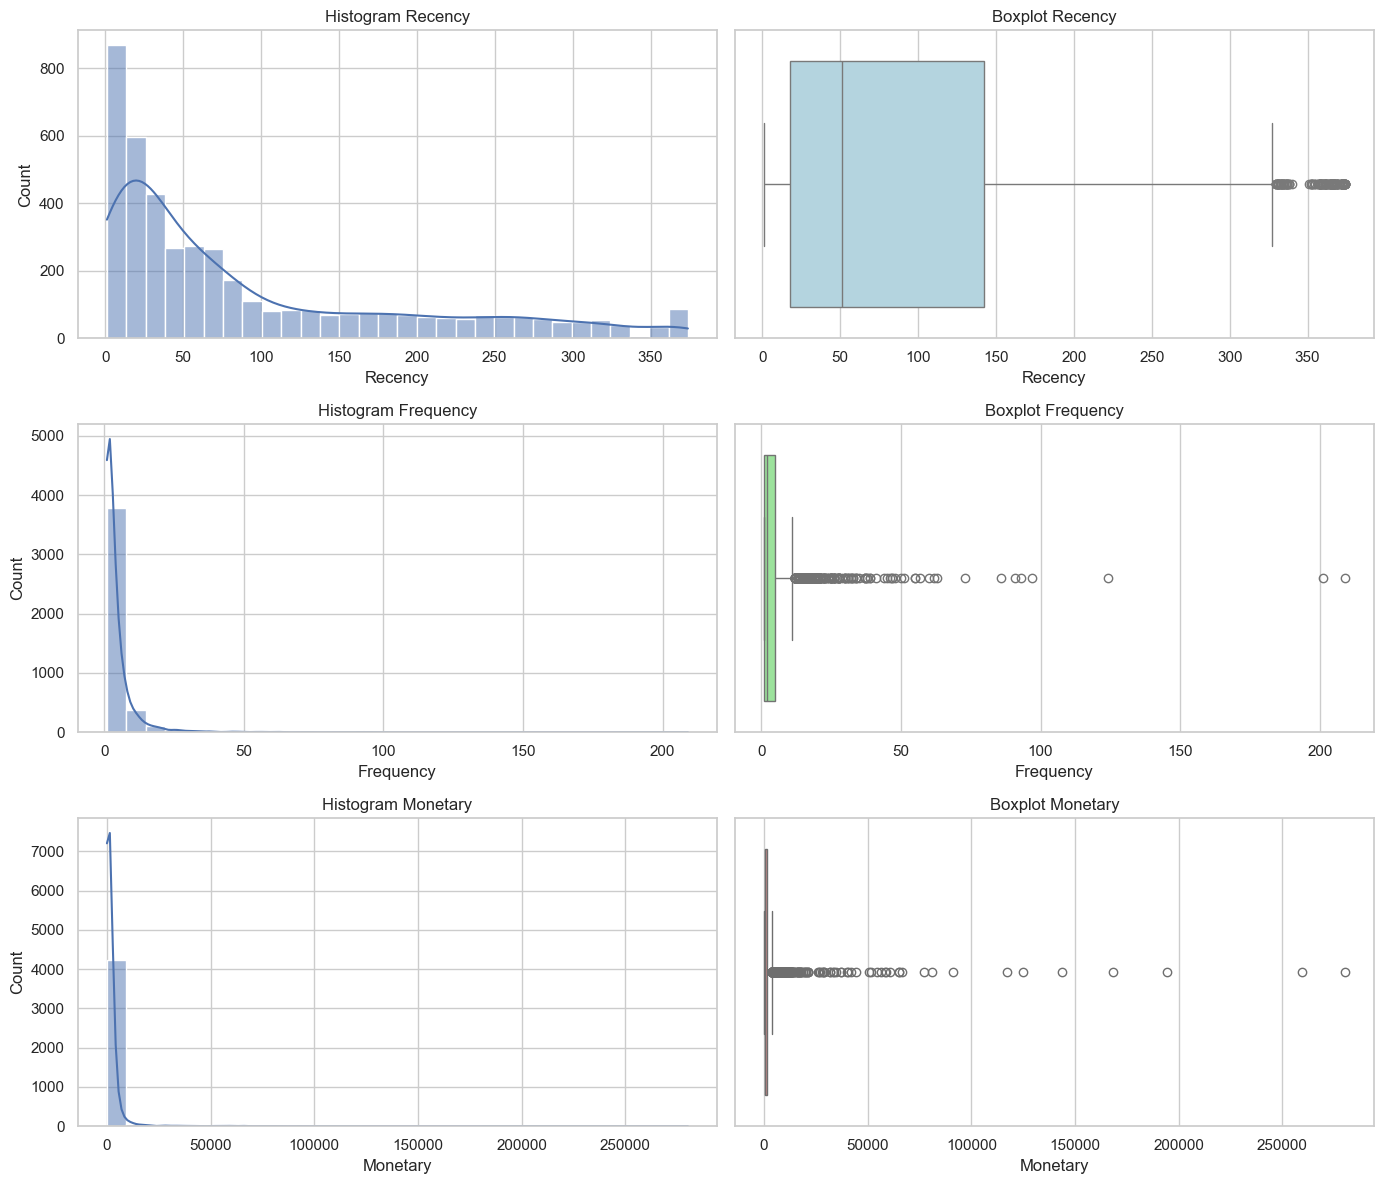

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style visualisasi
sns.set(style='whitegrid')

# Visualisasi Histogram dan Boxplot untuk Recency, Frequency, Monetary
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Histogram
sns.histplot(rfm['Recency'], bins=30, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Histogram Recency')
sns.histplot(rfm['Frequency'], bins=30, ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Histogram Frequency')
sns.histplot(rfm['Monetary'], bins=30, ax=axes[2, 0], kde=True)
axes[2, 0].set_title('Histogram Monetary')

# Boxplot
sns.boxplot(x=rfm['Recency'], ax=axes[0, 1], color='lightblue')
axes[0, 1].set_title('Boxplot Recency')
sns.boxplot(x=rfm['Frequency'], ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_title('Boxplot Frequency')
sns.boxplot(x=rfm['Monetary'], ax=axes[2, 1], color='lightcoral')
axes[2, 1].set_title('Boxplot Monetary')
plt.tight_layout()
plt.show()

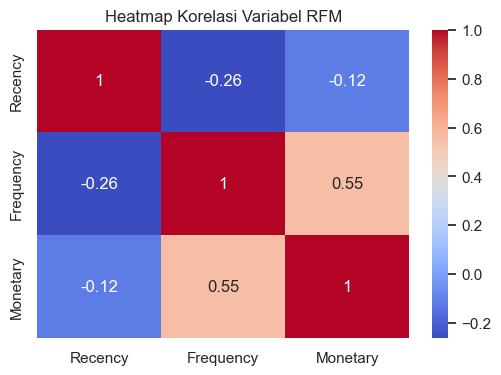

In [100]:
# Korelasi antar variabel numerik RFM
plt.figure(figsize=(6, 4))
sns.heatmap(rfm[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi Variabel RFM')
plt.show()


In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [102]:
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Segment'].apply(lambda x: 1 if x == 'Best' else 0)


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [105]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)


LogisticRegression()

In [106]:
y_pred = model.predict(X_test_scaled)

print("Akurasi:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Akurasi: 0.9585253456221198
Confusion Matrix:
[[759  14]
 [ 22  73]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       773
           1       0.84      0.77      0.80        95

    accuracy                           0.96       868
   macro avg       0.91      0.88      0.89       868
weighted avg       0.96      0.96      0.96       868

